In [5]:
import csv
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error
from numpy.linalg import pinv # pseudo-inverse

In [6]:
#read each element of the csv file, separate by commas as a row and put it in a list
path = 'dataset/solar_data.csv'

with open(path, 'r') as file:
    reader = csv.reader(file)
    data = list(reader)
    

In [7]:
data=np.array(data)
data=data.squeeze()

In [8]:
#convert data float
data = data.astype(float)

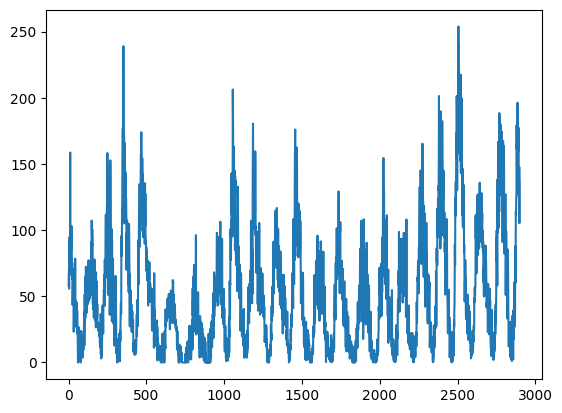

In [9]:
plt.plot(data)

In [131]:
class LSM():
    def __init__(self,  N_exc, N_inib, w_in_exc, w_in_inib, w_rec_exc, w_rec_inib ):
        re = np.random.rand(N_exc)
        ri = np.random.rand(N_inib)
        # parameters of the iziechevic dynamic
        self.a = np.concatenate((0.02*np.ones(N_exc), 0.02+0.08*ri))
        self.b = np.concatenate((0.2*np.ones(N_exc), 0.25-0.05*ri))
        self.c = np.concatenate((-65+15*re**2, -65*np.ones(N_inib)))
        self.d = np.concatenate((8-6*re**2, 2*np.ones(N_inib)))
        # weights
        self.in_weights = np.concatenate((w_in_exc*np.ones(N_exc), w_in_inib*np.ones(N_inib)))
        self.rec_weights = np.concatenate((w_rec_exc*np.random.rand(N_exc + N_inib, N_exc), -w_rec_inib*np.random.rand(N_exc+ N_inib, N_inib)), axis=1)
        # initial states
        self.u = -65*np.ones(N_exc+N_inib)  # Initial values of v
        self.w = self.b*self.u  # Initial values of w
        # outputs of the simulation
        

    def simulate(self, inputs):
        self.firings = []  # spike timings
        self.states = []  # here we construct the matrix of reservoir states
        for t, input in enumerate(inputs):
            I = input * self.in_weights
            fired = np.where(self.u >= 30)[0]  # indices of spikes
            self.firings.append(np.column_stack((t+np.zeros_like(fired), fired)))
            self.u[fired] = self.c[fired] # reset potential for neurons that fired
            self.w[fired] = self.w[fired] + self.d[fired] # reset recovery for neurons that fired
            I = I + np.sum(self.rec_weights[:, fired], axis=1) 
            self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # step 0.5 ms
            self.u = self.u + 0.5*(0.04*self.u**2 + 5*self.u + 140 - self.w + I)  # for numerical stability
            self.w = self.w + self.a*(self.b*self.u - self.w)
            # TODO use directly u 
            if bool_states:
                self.states.append(self.u >= 30)
            else
                self.states.append(self.u)
        self.firings = np.concatenate(self.firings)
        self.states=np.array(self.states).astype(int).astype(float).T
        return self.states, self.firings
    

In [132]:
input_dataset =data[:-1]
target_dataset= data[1:]


In [133]:
# split inputs and targets in train/test
input_train = input_dataset[:-500]
input_test = input_dataset[-500:]
target_train =target_dataset[:-500]
target_test = target_dataset[-500:]

In [134]:
# split training data in train/val for model selection
input_val = input_train[-300:]
input_train=input_train[:-300]
target_val = target_train[-300:]
target_train=target_train[:-300]

In [159]:
lsm = LSM(800, 200,5,2,0.5,1)
train_states, _ = lsm.simulate(input_train)

readout = target_train @ pinv(train_states)


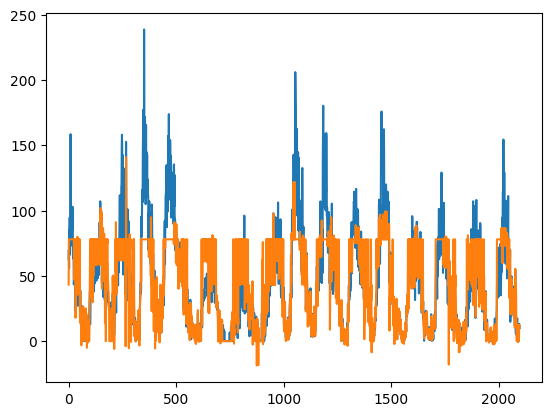

In [160]:
# predict training
pred_train = readout @ train_states
plt.plot(target_train)
plt.plot(pred_train)
plt.show()

In [153]:
mean_absolute_error(pred_train, target_train)


13.988598902191923

In [154]:
readout.shape

(1000,)

74.65420990587833

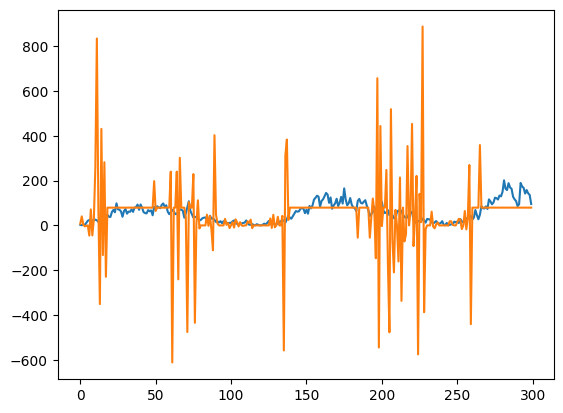

In [155]:
val_states ,_ = lsm.simulate(input_val)
pred_val =readout @ val_states
plt.plot(target_val)
plt.plot(pred_val)

mean_absolute_error(pred_val, target_val)
